In [7]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from io import StringIO
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('C:\\Users\\om sai\\Downloads\\Case Studies - Questions with Solutions-20191102\\Case 1\\Tractor-Sales.csv')

In [4]:
df.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [8]:
import calendar 

In [39]:
dates =pd.date_range(start='2003-01-01',freq='MS',periods=len(df))

In [40]:
df['Month']=dates.month
df['Month']= df['Month'].apply(lambda x: calendar.month_abbr[x])
df['Years'] = dates.year

In [41]:
##df.drop(['Month-Year'],axis=1,inplace=True)
df.rename(columns={'Number of Tractor Sold': 'Tractor-Sales'},inplace=True)
df=df[['Month','Years','Tractor-Sales']]

In [42]:
df.head()

,Month,Years,Tractor-Sales
2013-01-01,Jan,2003,141
2013-02-01,Feb,2003,157
2013-03-01,Mar,2003,185
2013-04-01,Apr,2003,199
2013-05-01,May,2003,203


In [43]:
df.set_index(dates,inplace=True)
df.head()

,Month,Years,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [44]:
sales_ts=df['Tractor-Sales']

Text(0, 0.5, 'Sales')

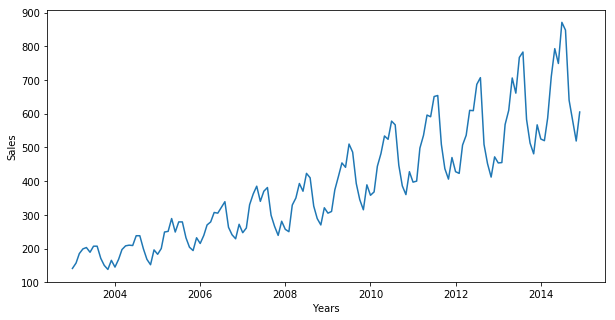

In [45]:
plt.figure(figsize=(10,5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Sales')

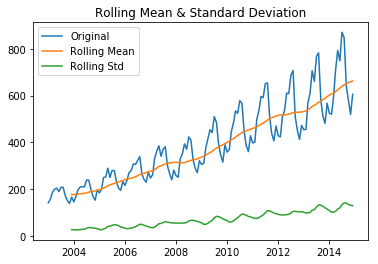

In [46]:
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


In [47]:
monthly_sales_data = pd.pivot_table(df, values = "Tractor-Sales", columns = "Years", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data


Years,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


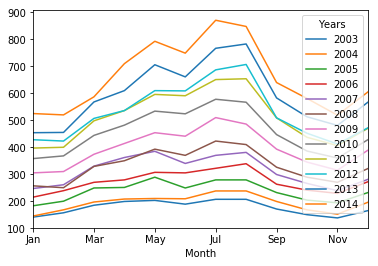

In [48]:
monthly_sales_data.plot()

In [49]:
decomposition = sm.tsa.seasonal_decompose(sales_ts,model='multiplicative')

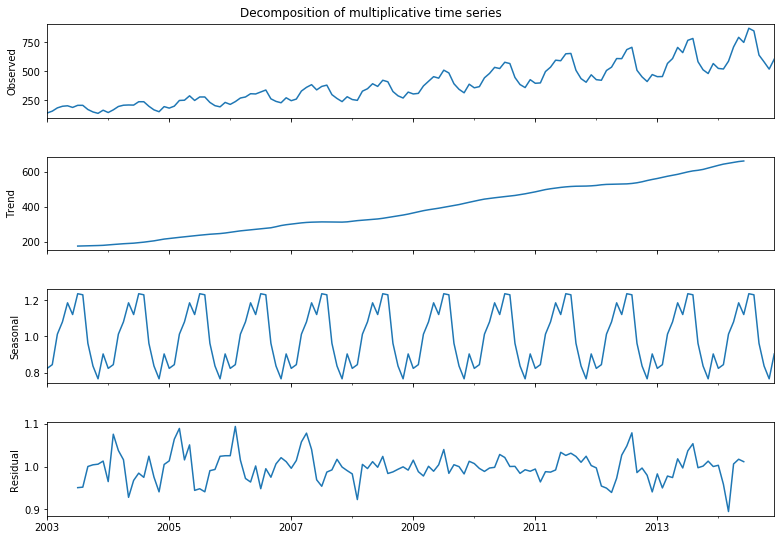

In [50]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [51]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [52]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [53]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 799.9064282670552 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [54]:
mod = sm.tsa.statespace.SARIMAX(sales_ts,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

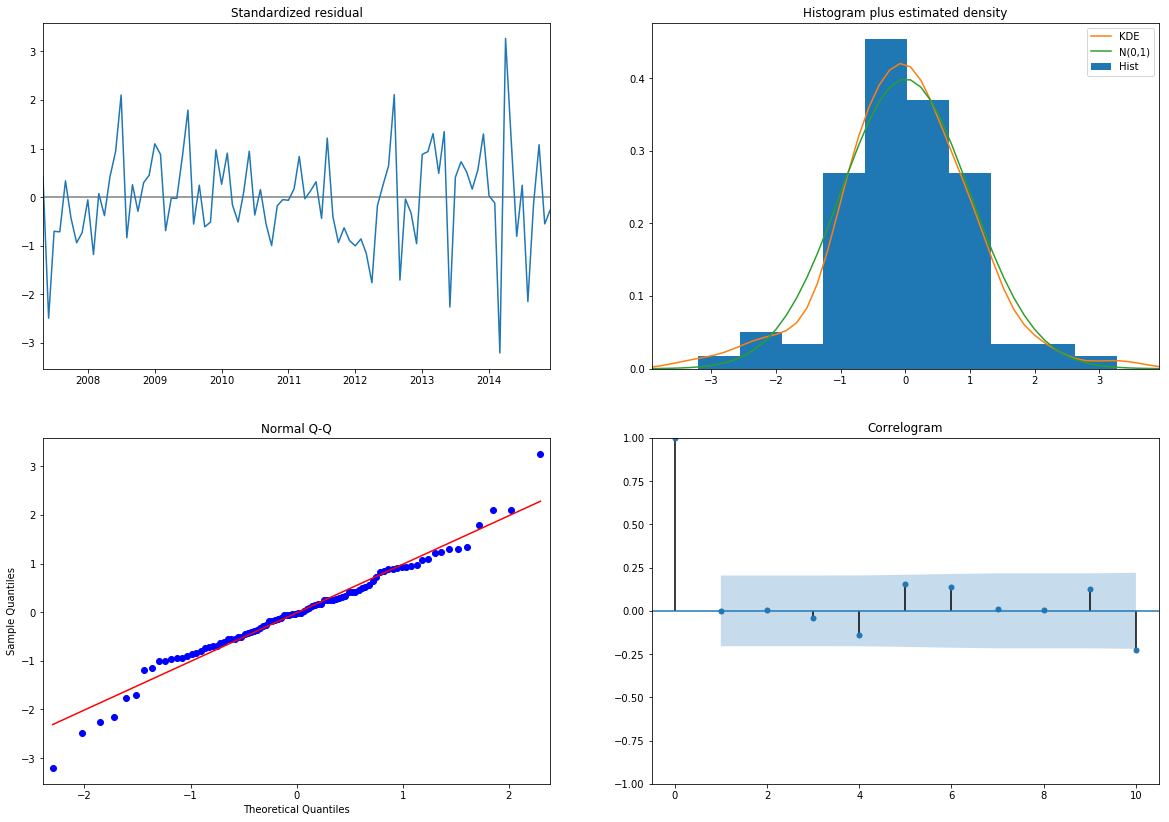

In [55]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [56]:
pred1 = results.get_prediction(start='2003-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [57]:
pred2 = results.get_forecast('2015-01-01')
pred2_ci = pred2.conf_int()

In [58]:
#In this case the model is used to predict data that the model was built on. 
#1-step ahead forecasting implies that each forecasted point is used to predict the 
#following one.
pred0 = results.get_prediction(start='2003-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

#In sample prediction with dynamic forecasting of the last year  
#Again, the model is used to predict data that the model was built on.
pred1 = results.get_prediction(start='2003-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

#"True" forecasting of out of sample data. 
#In this case the model is asked to predict data it has not seen before.
pred2 = results.get_forecast('2016-01-01')
# Give the end year till you want forecast
pred2_ci = pred2.conf_int()

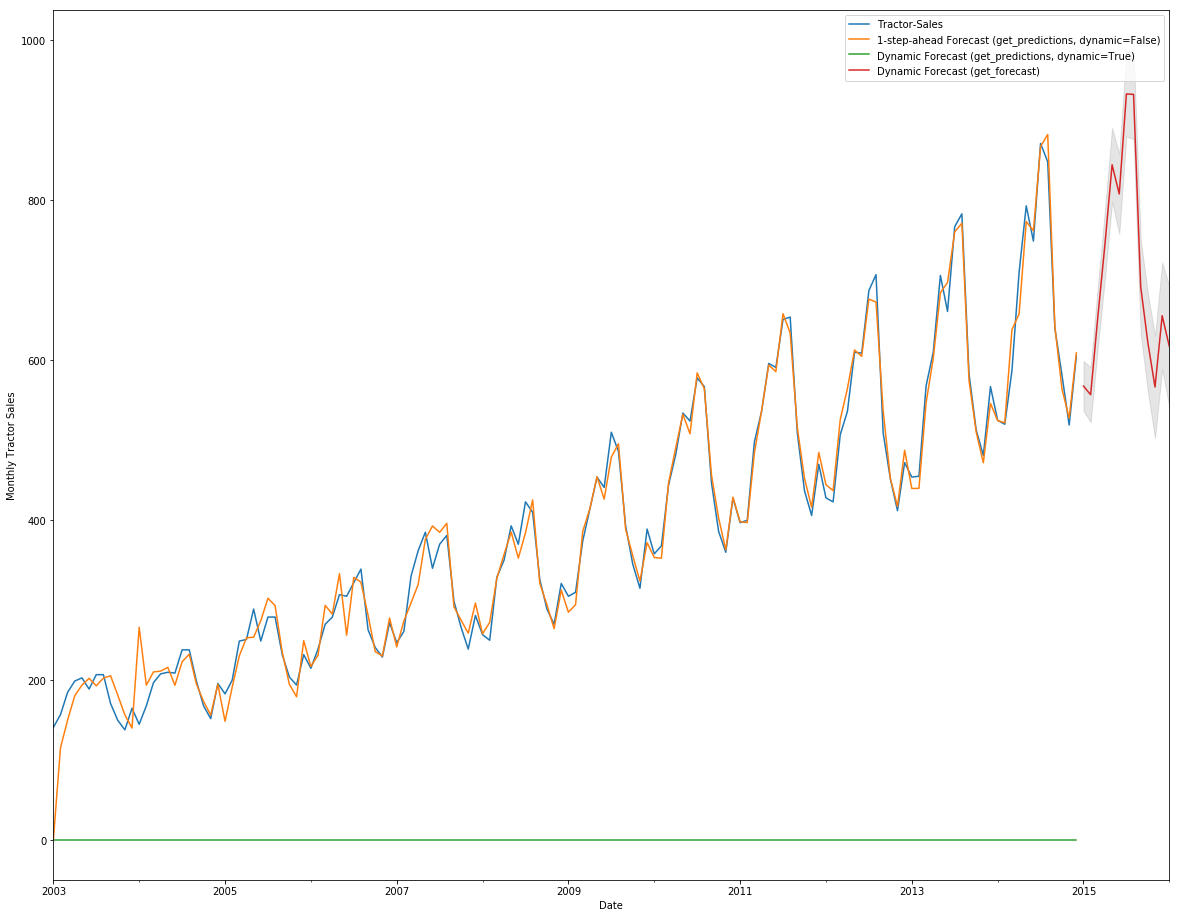

In [59]:
ax = sales_ts.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly Tractor Sales')
plt.xlabel('Date')
plt.legend()
plt.show()